## 1. Import Modules and Data
BERT can be fine-tined on Stanford Sentiment Treebank-2(SST2) dataset for text classification task. More info about SST2 can be found [here](https://huggingface.co/datasets/stanfordnlp/sst2).

In [1]:
import torch
from transformers import BertTokenizer, AdamW
from data import load_data
from modules.optim_schedule import ScheduledOptim
from modules.bert import BERTTextClassifier
import config 
# load sst-2
tokenizer, train_dataloader, valid_dataloader = load_data(
    name="sst2",
    loading_ratio=1,  # 加载100%的数据
    num_proc=4,  # 使用4个进程进行处理
    splits=["train", "validation"]  # load train and valid dataset
)

# check one batch
for batch in train_dataloader:
    input_ids, attention_mask, labels = batch
    print(input_ids.shape, attention_mask.shape, labels.shape)
    break


Using the latest cached version of the dataset since glue couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'sst2' at /root/.cache/huggingface/datasets/glue/sst2/0.0.0/bcdcba79d07bc864c1c254ccfcedcce55bcc9a8c (last modified on Wed Feb  5 17:36:25 2025).


torch.Size([16, 128]) torch.Size([16, 128]) torch.Size([16])


## 2. Build Model and Load from Pre-trained

Build a BERT text classification model which inherits from the BERT class and add a binary linear classification layer at the end of the structure.

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# load pretrained model
model = BERTTextClassifier.from_pretrained(
    config.pretrained_path,  
    num_frozen_layers=0,  
)
model = model.to(device)

print(model)


Number of trainable parameters: 108.89M
BERTTextClassifier(
  (embedding): BERTEmbedding(
    (token): TokenEmbedding(30522, 768, padding_idx=0)
    (position): PositionalEmbedding(512, 768)
    (segment): SegmentEmbedding(2, 768, padding_idx=0)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): ModuleList(
    (0): TransformerBlock(
      (self_attn): MultiheadAttention(
        (attention): ScaledDotProductAttention()
        (w_q): Linear(in_features=768, out_features=768, bias=True)
        (w_k): Linear(in_features=768, out_features=768, bias=True)
        (w_v): Linear(in_features=768, out_features=768, bias=True)
        (w_concat): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_1): LayerNorm()
      (ffn): PositionwiseFeedForward(
        (linear1): Linear(in_features=768, out_features=3072, bias=True)
        (linear2): Linear(in_features=3072, out_features=768, bias=True)
        (d

## 3. Train Model

### 3.1 Optimizer and Scheduler
ScheduledOptim class is a wrapper for an optimizer that implements a learning rate scheduling strategy inspired by the Transformer paper (Attention Is All You Need). It adjusts the learning rate using a warm-up and decay mechanism to stabilize training. You can check modules/optim_schedule.py for deeper understanding.

Original paper shows that they use Adam with learning rate of 1e-4, β1 = 0.9, β2 = 0.999, L2 weight decay of 0.01, learning rate warmup over the first 10,000 steps, and linear decay of the learning rate in the pretraining.

For fine-tuning, most model hyperparameters are the same as in pre-training, with the exception of the batch size, learning rate, and number of training epochs.
The dropout probability was always kept at 0.1. The optimal hyperparameter values are task-specific.


The learing rate schedule is shown as below, where initial lr is set as 5e-5.

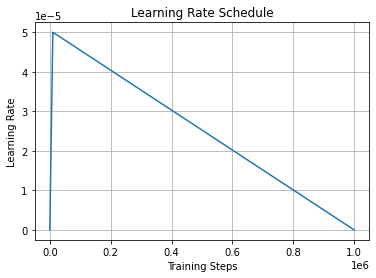

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import AdamW
from modules.optim_schedule import ScheduledOptim
import config

#random create one model
test_model = torch.nn.Linear(10, 1)


optimizer = AdamW(test_model.parameters(), lr=config.FinetuningConfig.lr, weight_decay=config.FinetuningConfig.weight_decay)

lr_values = []

scheduler = ScheduledOptim(optimizer,config.warmup_steps,config.total_steps)

for _ in range(config.total_steps):
    
    # update lr
    scheduler.step_and_update_lr()
    lr = optimizer.param_groups[0]['lr']
    lr_values.append(lr)
    


plt.plot(lr_values)
plt.title('Learning Rate Schedule')
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

### 3.2 Train Loop

In [3]:
import torch
from transformers import BertTokenizer
from torch.optim import AdamW

from data import load_data
from modules.optim_schedule import ScheduledOptim
from modules.bert import BERTTextClassifier
import config  

# finetune
pad_idx = 0 # 填充的标记
def split_batch(batch):  
    tokens, attention_mask, labels = batch 
    attention_mask = (tokens != pad_idx).long()  
    input_ids = tokens.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    return input_ids, attention_mask, labels

from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
@torch.no_grad()
def evaluate(model, clf_criterion, dataloader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(dataloader, desc="Evaluating"):
        input_ids, attention_mask, gt = split_batch(batch)

        clf_logits = model(input_ids)  # get classfier logits
        
        # print(f"evaluate_clf_logits: {clf_logits}")

        loss = clf_criterion(clf_logits, gt)
        total_loss += loss.item()

        preds = torch.argmax(clf_logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(gt.cpu().numpy())
        # get predictions and GT
        # print(f"Predictions: {preds.cpu().numpy()}")
        # print(f"Ground Truth: {gt.cpu().numpy()}")

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy


In [4]:
def train(epoch, model, scheduled_optimizer, dataloader):
    model.train()
    total_loss = 0
    scheduled_optimizer.zero_grad()  

    for batch in tqdm(dataloader, desc=f"Training Epoch {epoch}"):
        input_ids, attention_mask, labels = split_batch(batch)
        
        # single sentence, requiring no segment info
        segment_info = torch.zeros(input_ids.size(0), input_ids.size(1))

        input_ids = input_ids.to(device).long()  
        attention_mask = attention_mask.to(device).long()  
        segment_info = segment_info.to(device).long()  
        
        
        loss, logits = model(input_ids, segment_info=segment_info, labels=labels)
        
        loss.backward()
        # grad-clip
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # update step and lr
        scheduled_optimizer.step_and_update_lr()  # 使用 ScheduledOptim 的 step_and_update_lr

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [5]:
def training_loop(model, train_dataloader, valid_dataloader, optimizer, criterion, num_epochs, warmup_steps):

    scheduled_optimizer = ScheduledOptim(
        optimizer=optimizer,
        n_warmup_steps=warmup_steps,
        total_steps=len(train_dataloader) * num_epochs
    )

    for epoch in range(num_epochs):
        # train
        avg_train_loss = train(
            epoch + 1, model, scheduled_optimizer, train_dataloader
        )

        # evaluate
        avg_valid_loss, avg_acc = evaluate(model, criterion, valid_dataloader)

        print(
            f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f},",
            f"Validation Loss: {avg_valid_loss:.4f}, Accuracy: {avg_acc * 100:.2f}",
        )

        # save checkpoint
        checkpoint_path = config.checkpoint_dir / f"bert_clf_{epoch + 1}.pth"
        torch.save(
            {
                "epoch": epoch + 1,
                "model": model.state_dict(),
                "optimizer": scheduled_optimizer._optimizer.state_dict(),
                "scheduler": scheduled_optimizer.n_current_steps,  # 保存当前的步数
            },
            checkpoint_path,
        )


# AdamW optimizer
optimizer = AdamW(model.parameters(), lr=config.FinetuningConfig.lr, weight_decay=config.FinetuningConfig.weight_decay)

training_loop(model, train_dataloader, valid_dataloader, optimizer,torch.nn.CrossEntropyLoss(), config.FinetuningConfig.n_epoch, config.FinetuningConfig.warmup_steps)


Training Epoch 1:   0%|          | 0/4210 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1/3, Training Loss: 0.4556, Validation Loss: 0.4504, Accuracy: 80.05


Training Epoch 2:   0%|          | 0/4210 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2/3, Training Loss: 0.3068, Validation Loss: 0.5671, Accuracy: 79.59


Training Epoch 3:   0%|          | 0/4210 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 3/3, Training Loss: 0.3253, Validation Loss: 0.4880, Accuracy: 80.62
